In [24]:
import os
import glob
import time
import pickle
import cv2
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randint
from time import time
from tqdm import tqdm
import random

import collections
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.distributions import Categorical


from lib import dataset_factory_er21046
from lib import models as model_fuctory
from lib import loss_func
from lib import utils_er21046

In [25]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [26]:
    # seed値を固定して乱数で決まる値を固定
    seed = 7  # 好きな値にしてください，ここの値が同じであれば重みの初期値が同じになります．つまり全部の実験で同じ値を指定する．
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
# 学習済みモデルのディレクトリ
load_path = "./results_er21046/depth40/train_100/2000epoch_lr0x001_NAdam_100samples_with_RND"
num_gauss = 1

with open('./new_dataset_er21046/train100/divide_ids/data_train_100.pickle', mode='br') as fi:
    id_train = pickle.load(fi)
id_train = id_train[0].tolist()
print(len(id_train))
print(id_train)

with open('./evaluate_data_er21046/no_sampler_RND_only/divide_ids/data_test_100.pickle', mode='br') as fi:
    id_test = pickle.load(fi)
id_test = id_test[0].tolist()
print(len(id_test))
print(id_test)

#id_list = [i for i in range(160)] 
#print(id_train)
#print(id_test)


100
[41, 54, 99, 73, 62, 17, 14, 60, 66, 19, 27, 15, 23, 38, 13, 55, 61, 59, 28, 39, 65, 75, 85, 51, 4, 91, 58, 53, 68, 31, 32, 71, 92, 33, 96, 49, 20, 52, 0, 30, 80, 70, 64, 93, 26, 8, 76, 42, 21, 24, 90, 78, 46, 83, 57, 86, 56, 67, 47, 9, 7, 79, 48, 69, 94, 77, 12, 36, 45, 72, 3, 37, 25, 35, 84, 11, 16, 95, 10, 43, 5, 98, 34, 40, 2, 74, 29, 88, 63, 87, 1, 44, 50, 97, 22, 81, 82, 89, 18, 6]
100
[22, 25, 57, 6, 50, 33, 32, 26, 8, 37, 29, 71, 36, 56, 65, 69, 38, 28, 39, 41, 23, 1, 11, 43, 45, 79, 19, 92, 95, 81, 27, 94, 7, 16, 58, 83, 60, 74, 77, 18, 63, 99, 2, 17, 96, 12, 82, 31, 86, 87, 10, 97, 98, 76, 72, 20, 24, 48, 54, 67, 88, 90, 52, 89, 46, 40, 15, 42, 44, 59, 85, 62, 70, 3, 5, 14, 35, 78, 9, 93, 55, 13, 21, 30, 53, 34, 47, 84, 91, 73, 80, 75, 66, 51, 0, 49, 61, 4, 64, 68]


In [28]:
# データセット
train_data = dataset_factory_er21046.RGBD_DATASET(root="./new_dataset_er21046/train100", use_ids = id_train, train=True, img_size=150, crop_size=140)
test_data  = dataset_factory_er21046.RGBD_DATASET(root="./evaluate_data_er21046/no_sampler_RND_only", use_ids = id_test, train=False, img_size=150, crop_size=140)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True,
                                           drop_last=True)
test_loader  = torch.utils.data.DataLoader(test_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True,
                                           drop_last=False)

Number of data :  100
Number of data :  100


Train data
Test data
Train data (Aligned y-axis)


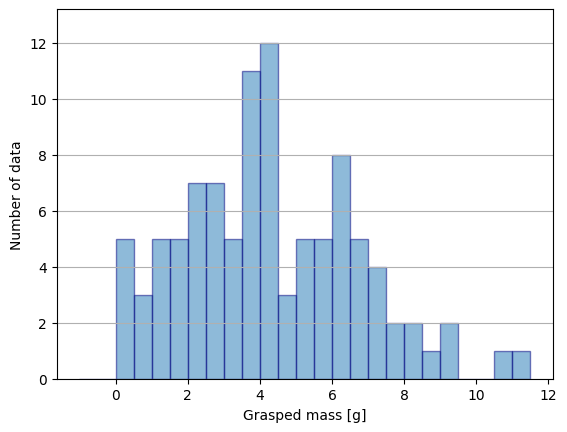

Test data (Aligned y-axis)


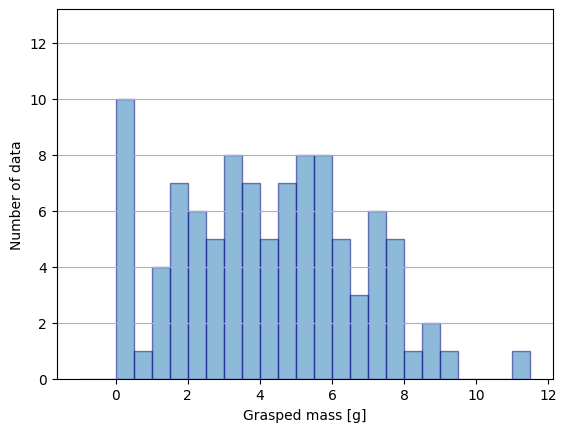

In [29]:
# Train data
print("Train data")
Y_train, X_train, _ = plt.hist(train_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5))
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
# 一旦プロットを閉じて最大値を確認
plt.close()

# Test data
print("Test data")
Y_test, X_test, _ = plt.hist(test_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5
                                                                                         ))
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
# 一旦プロットを閉じて最大値を確認
plt.close()

# y 軸の最大値を統一
y_max = max(max(Y_train), max(Y_test))

# 再プロット
print("Train data (Aligned y-axis)")
plt.hist(train_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5))
plt.grid(axis='y')
plt.ylim(0, y_max * 1.1)  # 少し余裕を持たせる
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
plt.show()

print("Test data (Aligned y-axis)")
plt.hist(test_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5))
plt.grid(axis='y')
plt.ylim(0, y_max * 1.1)  # 少し余裕を持たせる
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
plt.show()

In [30]:
# ネットワーク
net = model_fuctory.CNN_MDN(num_gaussians=num_gauss)
predict_net = model_fuctory.CNN_RND()
target_net  = model_fuctory.CNN_RND()

# 学習済み重みの読み込み
msg = net.load_state_dict(torch.load(os.path.join(load_path, 'checkpoint.pth'), map_location='cpu'))
print(msg)
msg = predict_net.load_state_dict(torch.load(os.path.join(load_path, 'predict_net.pth'), map_location='cpu'))
print(msg)
msg = target_net.load_state_dict(torch.load(os.path.join(load_path, 'target_net.pth'), map_location='cpu'))
print(msg)

# ネットワークをGPUへ
net = net.cuda()
predict_net = predict_net.cuda()
target_net  = target_net.cuda()

# RNDの損失式
criterion_rnd = nn.MSELoss(reduction='none').cuda()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


## 学習用データに対する予測結果の評価

### 各データに対するMDNが予測した把持量と標準偏差，計測した把持量-予測した把持量を可視化

In [31]:
data_ids = 0
train_difference_mass_list = []
train_target_mass_list  = []
train_predict_mass_list = []
train_predict_sigma_list = []
train_rnd_score_list  = []
target_gaku_list = []

net.eval()
predict_net.eval()
target_net.eval()
with torch.no_grad():
    for image_rgb, image_depth, z_gripper, target, use_id, item in train_loader:
        # 各データをGPUへ
        image_rgb   = image_rgb.cuda()
        image_depth = image_depth.cuda()
        z_gripper   = z_gripper.cuda()
        target      = target.cuda()
        
        target_gaku_list.extend(target.detach().cpu().numpy().tolist())
        #print(target_gaku_list)
        
        # 把持深さと把持量のTensorをreshape : torch.Size([2]) -> torch.Size([2,1])
        z_gripper = z_gripper.reshape([z_gripper.size()[0],-1])
        target    = target.reshape([target.size()[0],-1])*0.001
        
        # ネットワークによる予測
        pi, sigma, mu = net(image_rgb, image_depth, 0*z_gripper)
        output_rnd = predict_net(image_rgb, image_depth)
        target_rnd = target_net(image_rgb, image_depth)
        loss_rnd   = criterion_rnd(output_rnd, target_rnd)
        
        if pi.shape[-1] >= 1:
            # 使用するガウス分布をpiに基づいて決定
            pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
            # 決定したガウス分布に対応する平均値と標準偏差の値をgatherにより取り出し
            variance_samples = sigma.gather(1, pis).detach().squeeze()#.item()
            mean_samples = mu.detach().gather(1, pis).squeeze()#.item()
            
        for i in range(len(mu)):
            data_ids += 1
            if pi.shape[-1] >= 1:
                variance = variance_samples[i].item()
                mean = mean_samples[i].item()
            else:
                variance = sigma[i].item()
                mean = mu[i].item()
            #print("data : ", data_ids)
            #print("model prediction [kg] : {:.5f} , standard deviation : {:.10f}".format(mean, variance))
            #print("target mass [kg]      : {:.5f}".format(target[i].item()))
            #print("difference mass [kg]  : {:.5f}".format(target[i].item()-mean))
            #print("RND Score (MSE)       : {:.10f}\n".format(loss_rnd[i].mean().item()))
            train_target_mass_list.append(target[i].item()*1000)
            train_predict_mass_list.append(mean*1000)
            train_difference_mass_list.append( (target[i].item()-mean)*1000 )
            train_predict_sigma_list.append( variance*1000 )
            train_rnd_score_list.append( loss_rnd[i].mean().item() )
            
            # 画像の可視化
            """
            image = torch.permute(image_rgb[i], (1, 2, 0))
            depth = torch.permute(image_depth[i], (1, 2, 0))
            
            fig = plt.figure(figsize=(9,3))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(image.cpu())
            ax1.set_title("image")
            
            ax2 = fig.add_subplot(1, 2, 2)
            aximg = ax2.imshow(depth.cpu())
            fig.colorbar(aximg, ax=ax2)
            ax2.set_title("raw_depth")
            
            plt.show()
            #"""


### 各データに対する計測した把持量-予測した把持量をヒストグラムで表現
横軸：計測した把持量-予測した把持量  
縦軸：データ数

In [32]:
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0
for i in range(len(train_target_mass_list)):
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.01) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.01) >= train_predict_mass_list[i]:
            acc_count_pm1 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.05) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.05) >= train_predict_mass_list[i]:
            acc_count_pm5 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.10) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.10) >= train_predict_mass_list[i]:
            acc_count_pm10 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.15) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.15) >= train_predict_mass_list[i]:
            acc_count_pm15 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.20) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.20) >= train_predict_mass_list[i]:
            acc_count_pm20 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.30) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.30) >= train_predict_mass_list[i]:
            acc_count_pm30 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.40) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.40) >= train_predict_mass_list[i]:
            acc_count_pm40 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.50) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.50) >= train_predict_mass_list[i]:
            acc_count_pm50 += 1
    #print(train_target_mass_list[i])
    #print(train_predict_mass_list[i])
print("acc +-  1 % : ", acc_count_pm1/len(train_target_mass_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(train_target_mass_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(train_target_mass_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(train_target_mass_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(train_target_mass_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(train_target_mass_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(train_target_mass_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(train_target_mass_list) * 100)

acc +-  1 % :  29.166666666666668
acc +-  5 % :  81.25
acc +- 10 % :  89.58333333333334
acc +- 15 % :  91.66666666666666
acc +- 20 % :  92.70833333333334
acc +- 30 % :  93.75
acc +- 40 % :  93.75
acc +- 50 % :  94.79166666666666


In [33]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0

for i in range(len(train_target_mass_list)):
    diff_g = abs(train_predict_mass_list[i] - train_target_mass_list[i])
    if diff_g <= 0.5:
        acc_count_pm1g += 1
    if diff_g <= 1.0:
        acc_count_pm5g += 1
    if diff_g <= 1.5:
        acc_count_pm10g += 1
    if diff_g <= 2.0:
        acc_count_pm15g += 1
    if diff_g <= 2.5:
        acc_count_pm20g += 1

print("acc +- 0.5 g : ", acc_count_pm1g/len(train_target_mass_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm5g/len(train_target_mass_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm10g/len(train_target_mass_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm15g/len(train_target_mass_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm20g/len(train_target_mass_list) * 100)

acc +- 0.5 g :  100.0
acc +- 1.0 g :  100.0
acc +- 1.5 g :  100.0
acc +- 2.0 g :  100.0
acc +- 2.5 g :  100.0


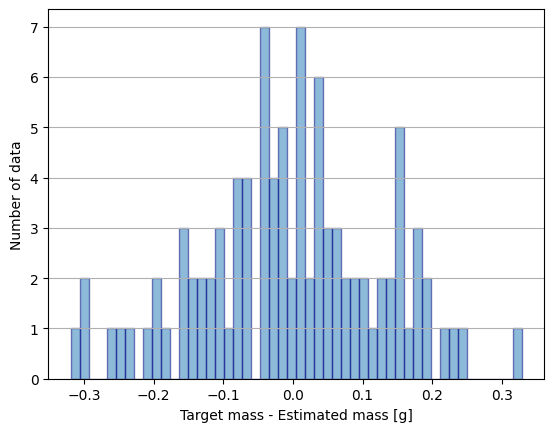

In [34]:
# 実際の把持量 - モデルの予測(平均値) の ヒストグラム
Y, X, _ = plt.hist(train_difference_mass_list, bins=50, alpha=0.5, ec='navy')
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Target mass - Estimated mass [g]')

#plt.xlim(-54.87830035854131, 54.87830035854131)
#plt.ylim(0.0, 48.3)
#plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
#plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])

#ax = plt.gca()
#x_range = ax.get_xlim()
#y_range = ax.get_ylim()
#print(x_range, y_range)

#plt.savefig("train_difference_mass_6000epoch.pdf")
plt.show()

### 各データに対する「計測した把持量-予測した把持量」と「予測した標準偏差」の関係を散布図で表現
横軸：計測した把持量-MDNが予測した把持量  
縦軸：MDNが予測した標準偏差

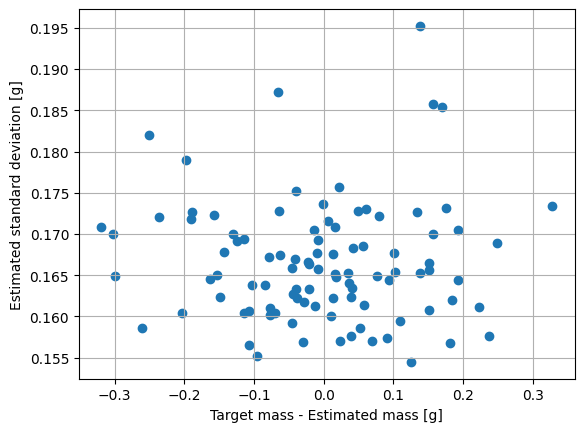

In [35]:
# 「計測した把持量-予測した把持量」 と 「予測した標準偏差」 の 散布図
plt.scatter(train_difference_mass_list, train_predict_sigma_list)
plt.grid()
plt.ylabel('Estimated standard deviation [g]')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()

横軸：計測した把持量-MDNが予測した把持量  
縦軸：RNDのスコア

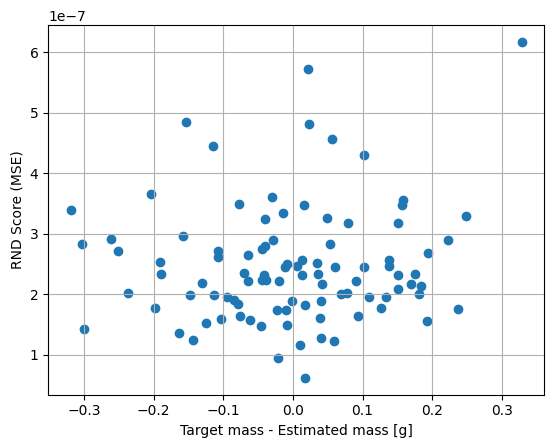

In [36]:
plt.scatter(train_difference_mass_list, train_rnd_score_list)
plt.grid()
plt.ylabel('RND Score (MSE)')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()

### 学習用データにおけるトレイ全体に対する把持量推定
1. トレイ全体をいくつかの領域に分割  
2. 分割した領域ごとに把持量と標準偏差を予測  
3. 予測した把持量と標準偏差をヒートマップ形式で可視化

## テスト用データに対する予測結果の評価

### 各データに対するMDNが予測した把持量と標準偏差，計測した把持量-予測した把持量を可視化

In [37]:
data_ids = 0
test_difference_mass_list = []
test_target_mass_list = []
test_predict_mass_list = []
test_predict_sigma_list = []
test_rnd_score_list  = []
target_test_list = []

net.eval()
predict_net.eval()
target_net.eval()
with torch.no_grad():
    for image_rgb, image_depth, z_gripper, target, use_id, item in test_loader:
        # 各データをGPUへ
        image_rgb   = image_rgb.cuda()
        image_depth = image_depth.cuda()
        z_gripper   = z_gripper.cuda()
        target      = target.cuda()
        
        target_test_list.extend(target.detach().cpu().numpy().tolist())
        
        # 把持深さと把持量のTensorをreshape : torch.Size([2]) -> torch.Size([2,1])
        z_gripper = z_gripper.reshape([z_gripper.size()[0],-1])
        target    = target.reshape([target.size()[0],-1]) * 0.001
        
        # ネットワークによる予測
        pi, sigma, mu = net(image_rgb, image_depth, 0*z_gripper)
        output_rnd = predict_net(image_rgb, image_depth)
        target_rnd = target_net(image_rgb, image_depth)
        loss_rnd   = criterion_rnd(output_rnd, target_rnd)
        
        if pi.shape[-1] >= 2:
            # 使用するガウス分布をpiに基づいて決定
            pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
            # 決定したガウス分布に対応する平均値と標準偏差の値をgatherにより取り出し
            variance_samples = sigma.gather(1, pis).detach().squeeze()#.item()
            mean_samples = mu.detach().gather(1, pis).squeeze()#.item()
            
        for i in range(len(mu)):
            data_ids += 1
            if pi.shape[-1] >= 2:
                variance = variance_samples[i].item()
                mean = mean_samples[i].item()
            else:
                variance = sigma[i].item()
                mean = mu[i].item()

            #print("data : ", data_ids)
            #print("model prediction [kg] : {:.5f} , standard deviation : {:.5f}".format(mean, variance))
            #print("targe mass [kg]       : {:.5f}".format(target[i].item()))
            #print("difference mass [kg]  : {:.5f}\n".format(target[i].item()-mean))
            #print("RND Score (MSE)       : {:.10f}\n".format(loss_rnd[i].mean().item()))
            test_target_mass_list.append(target[i].item()*1000)
            test_predict_mass_list.append(mean*1000)
            test_difference_mass_list.append( (target[i].item()-mean)*1000)
            test_predict_sigma_list.append( variance*1000)
            test_rnd_score_list.append( loss_rnd[i].mean().item() )
            
            # 画像の可視化
            """
            image = torch.permute(image_rgb[i], (1, 2, 0))
            depth = torch.permute(image_depth[i], (1, 2, 0))
            
            fig = plt.figure(figsize=(9,3))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(image.cpu())
            ax1.set_title("image")
            
            ax2 = fig.add_subplot(1, 2, 2)
            aximg = ax2.imshow(depth.cpu())
            fig.colorbar(aximg, ax=ax2)
            ax2.set_title("raw_depth")
            
            plt.show()
            #"""

### 各データに対する計測した把持量-予測した把持量をヒストグラムで表現
横軸：計測した把持量-予測した把持量  
縦軸：データ数

In [38]:
path_list = sorted(glob.glob( "./evaluate_data_er21046/no_sampler_RND_only/color/*"))

gram_e_list = []
gram_j_list = []

for i in range(len(path_list)):
    image_path = path_list[i]
    base_path = os.path.splitext(image_path)[0]
    
    # gram
    gram_path = base_path.split('/')
    gram_path[3] = "grams_txt" 
    gram_path = os.path.join(*gram_path) + ".csv"
    grams = np.genfromtxt(gram_path, delimiter=',')
    gram_e  = grams[1, 0]
    gram_j = grams[1, 1]
    
    gram_e_list.append(gram_e)
    gram_j_list.append(gram_j)

#print(gram_e_list)
#print(len(gram_e_list))
#print(gram_j_list)
#print(len(gram_j_list))
     
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0

for i in range(len(gram_j_list)):
    if (gram_j_list[i]-gram_j_list[i]*0.01) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.01) >= gram_e_list[i]:
            acc_count_pm1 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.05) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.05) >= gram_e_list[i]:
            acc_count_pm5 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.10) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.10) >= gram_e_list[i]:
            acc_count_pm10 += 1
    
    if (gram_j_list[i]-gram_j_list[i]*0.15) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.15) >= gram_e_list[i]:
            acc_count_pm15 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.20) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.20) >= gram_e_list[i]:
            acc_count_pm20 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.30) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.30) >= gram_e_list[i]:
            acc_count_pm30 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.40) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.40) >= gram_e_list[i]:
            acc_count_pm40 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.50) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.50) >= gram_e_list[i]:
            acc_count_pm50 += 1
    
    
            
print("acc +-  1 % : ", acc_count_pm1/len(gram_j_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(gram_j_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(gram_j_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(gram_j_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(gram_j_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(gram_j_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(gram_j_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(gram_j_list) * 100)

acc +-  1 % :  2.0
acc +-  5 % :  8.0
acc +- 10 % :  10.0
acc +- 15 % :  15.0
acc +- 20 % :  25.0
acc +- 30 % :  37.0
acc +- 40 % :  48.0
acc +- 50 % :  61.0


In [39]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0
acc_count_pm25g = 0
acc_count_pm30g = 0
acc_count_pm35g = 0
acc_count_pm40g = 0
acc_count_pm45g = 0
acc_count_pm50g = 0
acc_count_pm55g = 0
acc_count_pm60g = 0
acc_count_pm65g = 0 
acc_count_pm70g = 0

for i in range(len(gram_j_list)):
    diff_g = abs(gram_j_list[i] - gram_e_list[i])
    if diff_g <= 0.1:
        acc_count_pm1g += 1
    if diff_g <= 0.5:
        acc_count_pm5g += 1
    if diff_g <= 1.0:
        acc_count_pm10g += 1
    if diff_g <= 1.5:
        acc_count_pm15g += 1
    if diff_g <= 2.0:
        acc_count_pm20g += 1
    if diff_g <= 2.5:
        acc_count_pm25g += 1
    if diff_g <= 3.0:
        acc_count_pm30g += 1  
    if diff_g <= 3.5:
        acc_count_pm35g += 1  
    if diff_g <= 4.0:
        acc_count_pm40g += 1 
    if diff_g <= 4.5:
        acc_count_pm45g += 1 
    if diff_g <= 5.0:
        acc_count_pm50g += 1  
    if diff_g <= 5.5:
        acc_count_pm55g += 1  
    if diff_g <= 6.0:
        acc_count_pm60g += 1    
    if diff_g <= 6.5:
        acc_count_pm65g += 1  
    if diff_g <= 7.0:
        acc_count_pm70g += 1  
        
print("acc +- 0.1 g : ", acc_count_pm1g/len(gram_j_list) * 100)
print("acc +- 0.5 g : ", acc_count_pm5g/len(gram_j_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm10g/len(gram_j_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm15g/len(gram_j_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm20g/len(gram_j_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm25g/len(gram_j_list) * 100)
print("acc +- 3.0 g : ", acc_count_pm30g/len(gram_j_list) * 100)
print("acc +- 3.5 g : ", acc_count_pm35g/len(gram_j_list) * 100)
print("acc +- 4.0 g : ", acc_count_pm40g/len(gram_j_list) * 100)
print("acc +- 4.5 g : ", acc_count_pm45g/len(gram_j_list) * 100)
print("acc +- 5.0 g : ", acc_count_pm50g/len(gram_j_list) * 100)
print("acc +- 5.5 g : ", acc_count_pm55g/len(gram_j_list) * 100)
print("acc +- 6.0 g : ", acc_count_pm60g/len(gram_j_list) * 100)
print("acc +- 6.5 g : ", acc_count_pm65g/len(gram_j_list) * 100)
print("acc +- 7.0 g : ", acc_count_pm70g/len(gram_j_list) * 100)

acc +- 0.1 g :  7.000000000000001
acc +- 0.5 g :  14.000000000000002
acc +- 1.0 g :  28.999999999999996
acc +- 1.5 g :  45.0
acc +- 2.0 g :  54.0
acc +- 2.5 g :  57.99999999999999
acc +- 3.0 g :  73.0
acc +- 3.5 g :  82.0
acc +- 4.0 g :  88.0
acc +- 4.5 g :  90.0
acc +- 5.0 g :  96.0
acc +- 5.5 g :  97.0
acc +- 6.0 g :  98.0
acc +- 6.5 g :  99.0
acc +- 7.0 g :  100.0


In [40]:
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0
for i in range(len(test_target_mass_list)):
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.01) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.01) >= test_predict_mass_list[i]:
            acc_count_pm1 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.05) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.05) >= test_predict_mass_list[i]:
            acc_count_pm5 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.10) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.10) >= test_predict_mass_list[i]:
            acc_count_pm10 += 1
    
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.15) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.15) >= test_predict_mass_list[i]:
            acc_count_pm15 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.20) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.20) >= test_predict_mass_list[i]:
            acc_count_pm20 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.30) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.30) >= test_predict_mass_list[i]:
            acc_count_pm30 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.40) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.40) >= test_predict_mass_list[i]:
            acc_count_pm40 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.50) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.50) >= test_predict_mass_list[i]:
            acc_count_pm50 += 1
    
    
            
print("acc +-  1 % : ", acc_count_pm1/len(test_target_mass_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(test_target_mass_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(test_target_mass_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(test_target_mass_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(test_target_mass_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(test_target_mass_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(test_target_mass_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(test_target_mass_list) * 100)

#print(test_target_mass_list)
#print(len(test_target_mass_list))
#print("")
#print(test_predict_mass_list)

acc +-  1 % :  2.0
acc +-  5 % :  8.0
acc +- 10 % :  10.0
acc +- 15 % :  15.0
acc +- 20 % :  26.0
acc +- 30 % :  38.0
acc +- 40 % :  48.0
acc +- 50 % :  62.0


In [41]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0
acc_count_pm25g = 0
acc_count_pm30g = 0
acc_count_pm35g = 0
acc_count_pm40g = 0
acc_count_pm45g = 0
acc_count_pm50g = 0
acc_count_pm55g = 0
acc_count_pm60g = 0
acc_count_pm65g = 0
acc_count_pm70g = 0

for i in range(len(test_target_mass_list)):
    diff_g = abs(test_predict_mass_list[i] - test_target_mass_list[i])
    if diff_g <= 0.1:
        acc_count_pm1g += 1
    if diff_g <= 0.5:
        acc_count_pm5g += 1
    if diff_g <= 1.0:
        acc_count_pm10g += 1
    if diff_g <= 1.5:
        acc_count_pm15g += 1
    if diff_g <= 2.0:
        acc_count_pm20g += 1
    if diff_g <= 2.5:
        acc_count_pm25g += 1
    if diff_g <= 3.0:
        acc_count_pm30g += 1  
    if diff_g <= 3.5:
        acc_count_pm35g += 1  
    if diff_g <= 4.0:
        acc_count_pm40g += 1 
    if diff_g <= 4.5:
        acc_count_pm45g += 1 
    if diff_g <= 5.0:
        acc_count_pm50g += 1  
    if diff_g <= 5.5:
        acc_count_pm55g += 1  
    if diff_g <= 6.0:
        acc_count_pm60g += 1    
    if diff_g <= 6.5:
        acc_count_pm65g += 1  
    if diff_g <= 7.0:
        acc_count_pm70g += 1  
        
print("acc +- 0.1 g : ", acc_count_pm1g/len(test_target_mass_list) * 100)
print("acc +- 0.5 g : ", acc_count_pm5g/len(test_target_mass_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm10g/len(test_target_mass_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm15g/len(test_target_mass_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm20g/len(test_target_mass_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm25g/len(test_target_mass_list) * 100)
print("acc +- 3.0 g : ", acc_count_pm30g/len(test_target_mass_list) * 100)
print("acc +- 3.5 g : ", acc_count_pm35g/len(test_target_mass_list) * 100)
print("acc +- 4.0 g : ", acc_count_pm40g/len(test_target_mass_list) * 100)
print("acc +- 4.5 g : ", acc_count_pm45g/len(test_target_mass_list) * 100)
print("acc +- 5.0 g : ", acc_count_pm50g/len(test_target_mass_list) * 100)
print("acc +- 5.5 g : ", acc_count_pm55g/len(test_target_mass_list) * 100)
print("acc +- 6.0 g : ", acc_count_pm60g/len(test_target_mass_list) * 100)
print("acc +- 6.5 g : ", acc_count_pm65g/len(test_target_mass_list) * 100)
print("acc +- 7.0 g : ", acc_count_pm70g/len(test_target_mass_list) * 100)

acc +- 0.1 g :  7.000000000000001
acc +- 0.5 g :  13.0
acc +- 1.0 g :  28.999999999999996
acc +- 1.5 g :  44.0
acc +- 2.0 g :  54.0
acc +- 2.5 g :  57.99999999999999
acc +- 3.0 g :  74.0
acc +- 3.5 g :  82.0
acc +- 4.0 g :  88.0
acc +- 4.5 g :  90.0
acc +- 5.0 g :  96.0
acc +- 5.5 g :  97.0
acc +- 6.0 g :  98.0
acc +- 6.5 g :  99.0
acc +- 7.0 g :  100.0


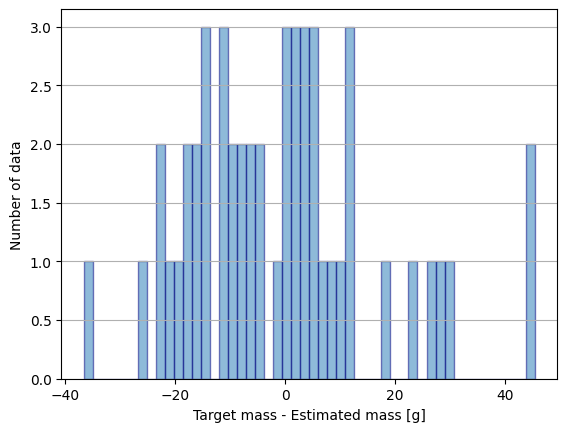

In [559]:
# 実際の把持量 - モデルの予測(平均値) の ヒストグラム
Y, X, _ = plt.hist(test_difference_mass_list, bins=50, alpha=0.5, ec='navy')
plt.grid(axis='y')
#plt.yticks([0, 1, 2, 3, 4])
plt.ylabel('Number of data')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("test_difference_mass_500epoch.pdf")
plt.show()

### 各データに対する「計測した把持量-予測した把持量」と「予測した標準偏差」の関係を散布図で表現
横軸：計測した把持量-MDNが予測した把持量  
縦軸：MDNが予測した標準偏差

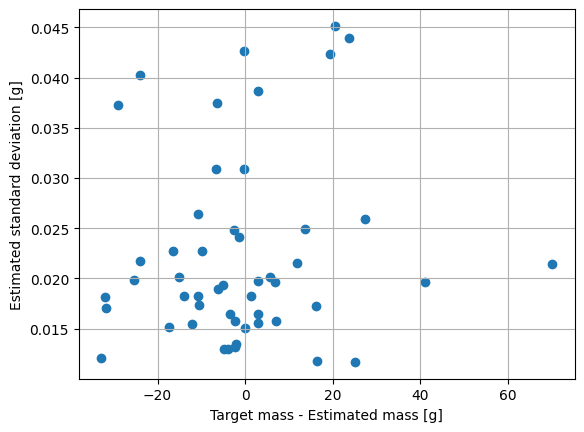

In [513]:
# 「計測した把持量-予測した把持量」 と 「予測した標準偏差」 の 散布図
plt.scatter(test_difference_mass_list, test_predict_sigma_list)
plt.grid()
plt.ylabel('Estimated standard deviation [g]')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("test_scatter_mass_sd_6000epoch.pdf")
plt.show()

横軸：計測した把持量-MDNが予測した把持量  
縦軸：RNDのスコア

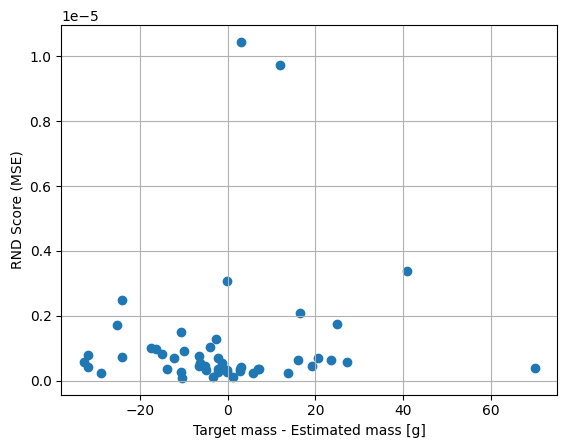

In [514]:
plt.scatter(test_difference_mass_list, test_rnd_score_list)
plt.grid()
plt.ylabel('RND Score (MSE)')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()